In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
file_path = "/content/drive/MyDrive/combined_dataset.csv"  # Adjust path if needed
data = pd.read_csv(file_path)  # Update path


Original shape: (28789809, 13)
After dropping NA: (28789809, 13)

Class distribution:
Label
1    20007392
0     8782417
Name: count, dtype: int64

Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [12:44:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training completed in 138.74 seconds

=== Evaluation Metrics ===
Accuracy: 0.9931
Precision: 0.9993
Recall: 0.9908
F1-Score: 0.9950
ROC AUC: 0.9977


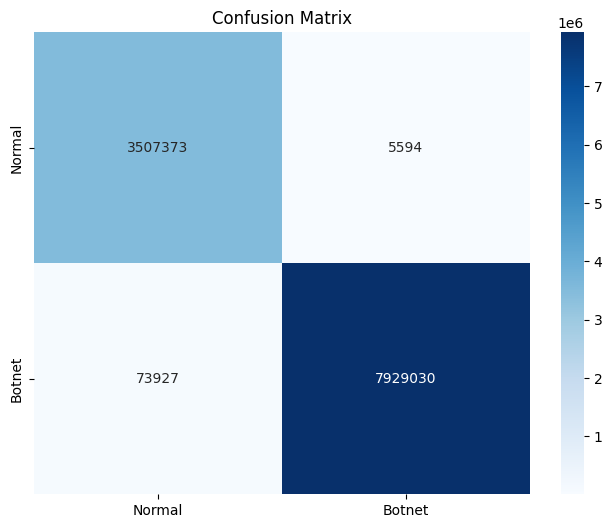

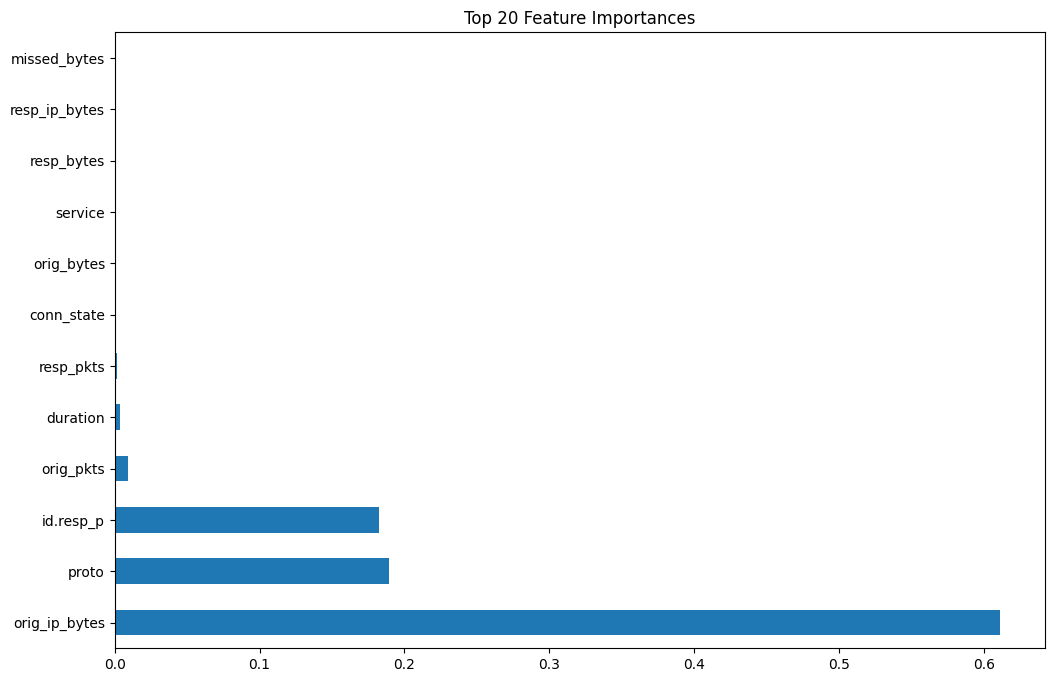


Model saved to 'xgboost_raw_model.pkl'


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                           accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib

# Load dataset
print("Original shape:", data.shape)

# Data Cleaning
data = data.dropna()
print("After dropping NA:", data.shape)

# Feature-Target Split
X = data.drop('Label', axis=1)
y = data['Label']

# Check class distribution
print("\nClass distribution:")
print(y.value_counts())

# Train-Test Split (Stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

# XGBoost Model - No class balancing
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    tree_method='hist'  # Faster training
)

# Train Model
print("\nTraining XGBoost...")
start_time = time.time()
xgb.fit(X_train, y_train)
print(f"Training completed in {time.time() - start_time:.2f} seconds")

# Predictions
y_pred = xgb.predict(X_test)
y_prob = xgb.predict_proba(X_test)[:, 1]  # Probabilities

# Evaluation Metrics
print("\n=== Evaluation Metrics ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Botnet'],
            yticklabels=['Normal', 'Botnet'])
plt.title('Confusion Matrix')
plt.show()

# Feature Importance
plt.figure(figsize=(12,8))
feat_importances = pd.Series(xgb.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.title('Top 20 Feature Importances')
plt.show()

# Save Model
joblib.dump(xgb, 'xgboost_raw_model.pkl')
print("\nModel saved to 'xgboost_raw_model.pkl'")